In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from tensorflow.keras import datasets, layers, models
from keras_tuner import HyperModel, HyperParameters, RandomSearch
import keras_tuner as kt

In [2]:
from PIL import Image
import os

# create data generators

In [3]:
target_size = (120,120)

In [4]:
batch_size = 128

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range = .3,
    zoom_range = .3,
    horizontal_flip=True,
    brightness_range = [.4,1.5],
    rotation_range = 30,
    width_shift_range=0.15,
    height_shift_range=0.15
    #featurewise_std_normalization=False # not sure how this will work here
)

In [6]:
train_generator = train_datagen.flow_from_directory(
        r'C:/Users/natha/OneDrive/Desktop/datascience/machine learning and predictive/final/dataset/output/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 32938 images belonging to 151 classes.


In [7]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [8]:
test_data_generator = test_datagen.flow_from_directory(
    r'C:/Users/natha/OneDrive/Desktop/datascience/machine learning and predictive/final/dataset/output/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8314 images belonging to 151 classes.


# tune hyper parameters

In [9]:
#,validation_data = test_data_generator

In [10]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()

        # Define the hyperparameter search space for Conv2D
        filters = hp.Int('filters', min_value=32, max_value=224, step=32)
        #filters2 = hp.Int('filters2', min_value=32, max_value=224, step=32)
        kernel_size = hp.Choice('kernel_size', values=[3, 5])
        pool_size = hp.Choice('pool_size', values=[2, 3])
        
        # Add the Conv2D layer with tunable hyperparameters
        model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=self.input_shape))
        model.add(layers.MaxPooling2D(pool_size=pool_size))
        
        #model.add(layers.Conv2D(filters=filters2, kernel_size=[5,5], activation='relu', input_shape=self.input_shape))
        #model.add(layers.MaxPooling2D(pool_size=(2,2)))
        
        model.add(layers.Dropout(.5))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=hp.Int('units', min_value=320, max_value=512, step=64), activation='relu'))
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2,.001])),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model



In [11]:
# Specify the input shape and number of classes
input_shape = (120, 120, 3)
num_classes = 151

# Create an instance of the custom HyperModel
hypermodel = MyHyperModel(input_shape, num_classes)

# Create a HyperParameters object
#hyperparameters = HyperParameters()

# Define the search space for filters and kernel_size
#hyperparameters.Int('filters', min_value=64, max_value=128, step=32)
#hyperparameters.Choice('kernel_size', values=[3, 5])
#hyperparameters.Choice('pool_size', values=[2, 3])


In [12]:
# Create a RandomSearch tuner with the hypermodel and hyperparameters
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=14,
    #hyperparameters=hyperparameters,
    directory='my_directory3',  # Specify a directory to store the tuner results
    project_name='my_project'  # Specify a project name for the tuner
)



In [13]:
# Perform the hyperparameter search
tuner.search(train_generator, epochs=3,steps_per_epoch = 16, validation_data=(test_data_generator))



Trial 14 Complete [00h 11m 26s]
val_accuracy: 0.00998316053301096

Best val_accuracy So Far: 0.018883811309933662
Total elapsed time: 02h 13m 58s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [15]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [17]:
print(best_hyperparameters.get('filters'))

print(best_hyperparameters.get('pool_size'))
print(best_hyperparameters.get('kernel_size'))

print(best_hyperparameters.get('units'))
print(best_hyperparameters.get('learning_rate'))

32
3
5
384
0.001


In [ ]:
best_model.summary()

# run actual model

In [95]:
classifier = keras.Sequential()

# Add the Conv2D layer with tunable hyperparameters
classifier.add(layers.Conv2D(filters=64, kernel_size=[5,5], activation='relu', input_shape=(64,64,3)))
classifier.add(layers.MaxPooling2D(pool_size=(3,3)))

#classifier.add(layers.Conv2D(filters=224, kernel_size=[5,5], activation='relu'))
#classifier.add(layers.MaxPooling2D(pool_size=(2,2)))

classifier.add(layers.Dropout(.5))
classifier.add(layers.Flatten())
classifier.add(layers.Dense(512, activation='relu'))
classifier.add(layers.Dense(151, activation='softmax'))


In [96]:
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [97]:
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        4864      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 25600)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               13107712  
                                                                 
 dense_15 (Dense)            (None, 151)               77463     
                                                      

In [108]:
history = classifier.fit(train_generator,epochs=1,random_state = 42)

258/258 [==============================] - 527s 2s/step - loss: 2.7438 - accuracy: 0.3661


In [99]:
hisorydf = pd.DataFrame(history.history)

In [100]:
hisorydf

,loss,accuracy
0,4.309054,0.093600
1,3.551414,0.215344
2,3.184457,0.276550


In [ ]:
import matplotlib.pyplot as plt

KeyError: 'val_accuracy'

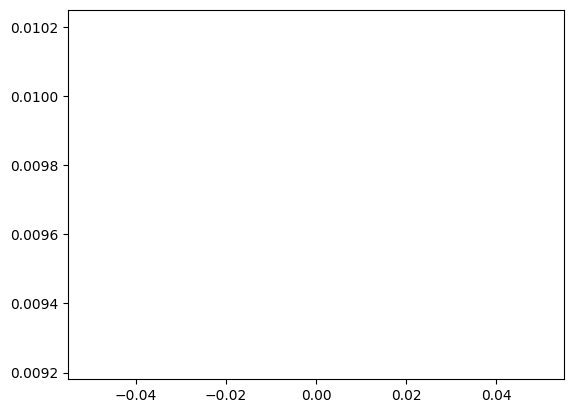

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [109]:
import h5py

In [110]:
from keras.models import load_model, save_model
classifier.save('my_model.h5')
print("Saved model")

Saved model


In [118]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

#load the image
my_image = load_img('whothatpokemon/pikachu.png', target_size=target_size)

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = classifier.predict(my_image)

1/1 [==============================] - 0s 20ms/step


In [119]:
class_labels = []
for i in os.listdir('output/train'):
    class_labels.append(i)

In [120]:
class_labels 

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur',
 'Butterfree',
 'Caterpie',
 'Chansey',
 'Charizard',
 'Charmander',
 'Charmeleon',
 'Clefable',
 'Clefairy',
 'Cloyster',
 'Cubone',
 'Dewgong',
 'Diglett',
 'Ditto',
 'Dodrio',
 'Doduo',
 'Dragonair',
 'Dragonite',
 'Dratini',
 'Drowzee',
 'Dugtrio',
 'Eevee',
 'Ekans',
 'Electabuzz',
 'Electrode',
 'Exeggcute',
 'Exeggutor',
 'Farfetchd',
 'Fearow',
 'Flareon',
 'Gastly',
 'Gengar',
 'Geodude',
 'Gloom',
 'Golbat',
 'Goldeen',
 'Golduck',
 'Golem',
 'Graveler',
 'Grimer',
 'Growlithe',
 'Gyarados',
 'Haunter',
 'Hitmonchan',
 'Hitmonlee',
 'Horsea',
 'Hypno',
 'Ivysaur',
 'Jigglypuff',
 'Jolteon',
 'Jynx',
 'Kabuto',
 'Kabutops',
 'Kadabra',
 'Kakuna',
 'Kangaskhan',
 'Kingler',
 'Koffing',
 'Krabby',
 'Lapras',
 'Lickitung',
 'Machamp',
 'Machoke',
 'Machop',
 'Magikarp',
 'Magmar',
 'Magnemite',
 'Magneton',
 'Mankey',
 'Marowak',
 'Meowth',
 'Metapod',


In [121]:
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

print(f"The predicted class is: {predicted_class_label}")

The predicted class is: Butterfree
